# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns

In [3]:
from icecream import ic

In [4]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
from dataset.cityscapes import Cityscapes
from dataset.cityscapes import CityscapesDataModule
from dataset.woodscape import WoodScapeDataset
from dataset.woodscape import WoodScapeDataModule
from dataset import WoodScapeSoilingDataset
from dataset import WoodScapeSoilingDataModule

In [6]:
from utils.display_images import denormalize_img
from utils import show_dataset_image, show_dataset_mask
from utils import show_prediction_images, show_prediction_uncertainty_images

In [7]:
from deeplab_v3p import DeepLabV3PlusModule
from dropblock import DropBlock2D

In [8]:
from ls_ood_detect.uncertainty_estimation import Hook
from ls_ood_detect.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect.uncertainty_estimation import get_dl_h_z
from ls_ood_detect.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect.detectors import KDEClassifier, DetectorKDE
from ls_ood_detect.score import get_hz_scores
from ls_ood_detect.metrics import get_hz_detector_results
from ls_ood_detect.metrics import get_ood_detector_results
from ls_ood_detect.metrics import plot_roc_ood_detector
from ls_ood_detect.metrics import plot_auprc_ood_detector
from ls_ood_detect.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect.dimensionality_reduction import apply_pca_ds_split
from ls_ood_detect.dimensionality_reduction import apply_pca_transform

# Load Entropy

In [9]:
data_path = "./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-woodscape/embeddings/woodscape/entropy/"

In [10]:
ws_dlv3p_h_z_ws_normal_train_samples_np = np.load(data_path + 'ws_dlv3p_h_z_ws_normal_train_samples_np.npy')

ws_dlv3p_h_z_ws_normal_valid_samples_np = np.load(data_path + 'ws_dlv3p_h_z_ws_normal_valid_samples_np.npy')

ws_dlv3p_h_z_ws_normal_test_samples_np = np.load(data_path + 'ws_dlv3p_h_z_ws_normal_test_samples_np.npy')

ws_dlv3p_h_z_ws_anomal_valid_samples_np = np.load(data_path + 'ws_dlv3p_h_z_ws_anomal_valid_samples_np.npy')

ws_dlv3p_h_z_ws_anomal_test_samples_np = np.load(data_path + 'ws_dlv3p_h_z_ws_anomal_test_samples_np.npy')

ws_dlv3p_h_z_cs_483640_valid_samples_np = np.load(data_path + 'ws_dlv3p_h_z_cs_483640_valid_samples_np.npy')

ws_dlv3p_h_z_cs_483640_test_samples_np = np.load(data_path + 'ws_dlv3p_h_z_cs_483640_test_samples_np.npy')

ws_dlv3p_h_z_ws_soil_483640_valid_samples_np = np.load(data_path + 'ws_dlv3p_h_z_ws_soil_483640_valid_samples_np.npy')

ws_dlv3p_h_z_ws_soil_483640_test_samples_np = np.load(data_path + 'ws_dlv3p_h_z_ws_soil_483640_test_samples_np.npy')

In [11]:
ic(ws_dlv3p_h_z_ws_normal_valid_samples_np.shape);
ic(ws_dlv3p_h_z_ws_normal_test_samples_np.shape);
ic(ws_dlv3p_h_z_ws_soil_483640_valid_samples_np.shape);
ic(ws_dlv3p_h_z_ws_soil_483640_test_samples_np.shape);

ic| ws_dlv3p_h_z_ws_normal_valid_samples_np.shape: (1482, 2048)
ic| ws_dlv3p_h_z_ws_normal_test_samples_np.shape: (823, 2048)
ic| ws_dlv3p_h_z_ws_soil_483640_valid_samples_np.shape: (800, 2048)
ic| ws_dlv3p_h_z_ws_soil_483640_test_samples_np.shape: (1000, 2048)


# Entropy 2D Projection

(2964, 2048)
(2964, 1)
(2964, 2)


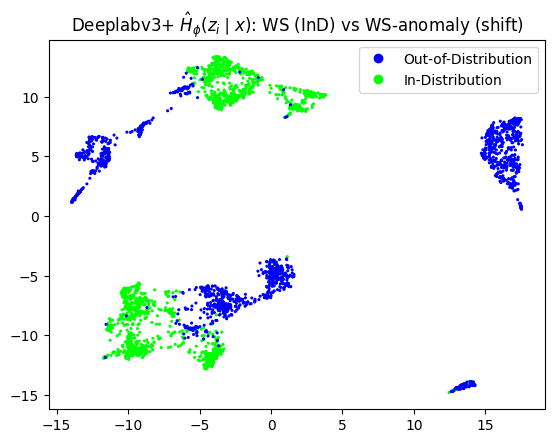

In [14]:
plot_samples_pacmap(ws_dlv3p_h_z_ws_normal_valid_samples_np,
                    ws_dlv3p_h_z_ws_anomal_valid_samples_np,
                    neighbors=14,
                    title="Deeplabv3+ $\hat{H}_{\phi}(z_i \mid x)$: WS (InD) vs WS-anomaly (shift)")

(1982, 2048)
(1982, 1)
(1982, 2)


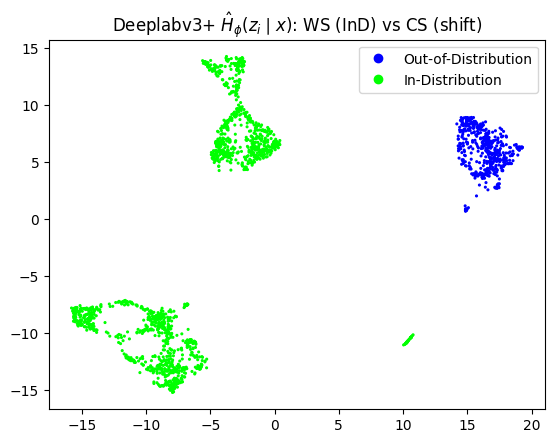

In [15]:
plot_samples_pacmap(ws_dlv3p_h_z_ws_normal_valid_samples_np,
                    ws_dlv3p_h_z_cs_483640_valid_samples_np,
                    neighbors=14,
                    title="Deeplabv3+ $\hat{H}_{\phi}(z_i \mid x)$: WS (InD) vs CS (shift)")

(2282, 2048)
(2282, 1)
(2282, 2)


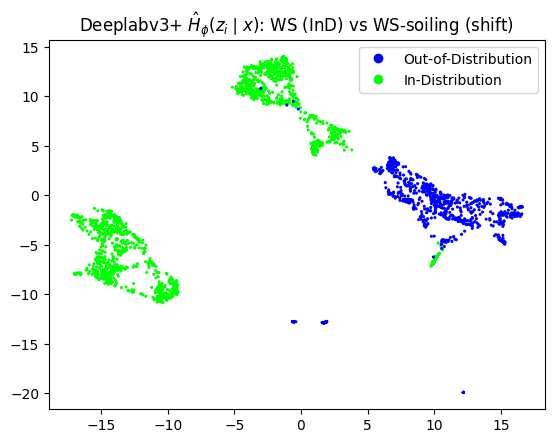

In [16]:
plot_samples_pacmap(ws_dlv3p_h_z_ws_normal_valid_samples_np,
                    ws_dlv3p_h_z_ws_soil_483640_valid_samples_np,
                    neighbors=14,
                    title="Deeplabv3+ $\hat{H}_{\phi}(z_i \mid x)$: WS (InD) vs WS-soiling (shift)")

# Build Deeplabv3+ Woodscape LaRED Distribution Shift Detector

In [12]:
ic(ws_dlv3p_h_z_ws_normal_train_samples_np.shape);
ic(ws_dlv3p_h_z_ws_normal_valid_samples_np.shape);
ic(ws_dlv3p_h_z_ws_normal_test_samples_np.shape);

ic(ws_dlv3p_h_z_ws_anomal_valid_samples_np.shape);
ic(ws_dlv3p_h_z_ws_anomal_test_samples_np.shape);

ic(ws_dlv3p_h_z_cs_483640_valid_samples_np.shape);
ic(ws_dlv3p_h_z_cs_483640_test_samples_np.shape);

ic(ws_dlv3p_h_z_ws_soil_483640_valid_samples_np.shape);
ic(ws_dlv3p_h_z_ws_soil_483640_test_samples_np.shape);

ic| ws_dlv3p_h_z_ws_normal_train_samples_np.shape: (5929, 2048)
ic| ws_dlv3p_h_z_ws_normal_valid_samples_np.shape: (1482, 2048)
ic| ws_dlv3p_h_z_ws_normal_test_samples_np.shape: (823, 2048)
ic| ws_dlv3p_h_z_ws_anomal_valid_samples_np.shape: (1482, 2048)
ic| ws_dlv3p_h_z_ws_anomal_test_samples_np.shape: (823, 2048)
ic| ws_dlv3p_h_z_cs_483640_valid_samples_np.shape: (500, 2048)
ic| ws_dlv3p_h_z_cs_483640_test_samples_np.shape: (1525, 2048)
ic| ws_dlv3p_h_z_ws_soil_483640_valid_samples_np.shape: (800, 2048)
ic| ws_dlv3p_h_z_ws_soil_483640_test_samples_np.shape: (1000, 2048)


## PCA Dimensionality Reduction

In [31]:
pca_ws_dlv3p_h_z_ws_normal_train_samples_np, pca_tr = apply_pca_ds_split(samples=ws_dlv3p_h_z_ws_normal_train_samples_np,
                                                                         nro_components=50)

In [32]:
pca_ws_dlv3p_h_z_ws_normal_valid_samples_np = apply_pca_transform(ws_dlv3p_h_z_ws_normal_valid_samples_np, pca_tr) # InD
pca_ws_dlv3p_h_z_ws_normal_test_samples_np = apply_pca_transform(ws_dlv3p_h_z_ws_normal_test_samples_np, pca_tr) # InD

pca_ws_dlv3p_h_z_ws_anomal_valid_samples_np= apply_pca_transform(ws_dlv3p_h_z_ws_anomal_valid_samples_np, pca_tr) # OoD | Anomaly
pca_ws_dlv3p_h_z_ws_anomal_test_samples_np = apply_pca_transform(ws_dlv3p_h_z_ws_anomal_test_samples_np, pca_tr) # OoD | Anomaly

pca_ws_dlv3p_h_z_cs_483640_valid_samples_np = apply_pca_transform(ws_dlv3p_h_z_cs_483640_valid_samples_np, pca_tr) # OoD | Anomaly
pca_ws_dlv3p_h_z_cs_483640_test_samples_np = apply_pca_transform(ws_dlv3p_h_z_cs_483640_test_samples_np, pca_tr) # OoD | Anomaly

pca_ws_dlv3p_h_z_ws_soil_483640_valid_samples_np = apply_pca_transform(ws_dlv3p_h_z_ws_soil_483640_valid_samples_np, pca_tr) # OoD | Anomaly
pca_ws_dlv3p_h_z_ws_soil_483640_test_samples_np = apply_pca_transform(ws_dlv3p_h_z_ws_soil_483640_test_samples_np, pca_tr) # OoD | Anomaly

In [33]:
ic(pca_ws_dlv3p_h_z_ws_normal_train_samples_np.shape);
ic(pca_ws_dlv3p_h_z_ws_normal_valid_samples_np.shape);
ic(pca_ws_dlv3p_h_z_ws_normal_test_samples_np.shape);

ic(pca_ws_dlv3p_h_z_ws_anomal_valid_samples_np.shape);
ic(pca_ws_dlv3p_h_z_ws_anomal_test_samples_np.shape);

ic(pca_ws_dlv3p_h_z_cs_483640_valid_samples_np.shape);
ic(pca_ws_dlv3p_h_z_cs_483640_test_samples_np.shape);

ic(pca_ws_dlv3p_h_z_ws_soil_483640_valid_samples_np.shape);
ic(pca_ws_dlv3p_h_z_ws_soil_483640_test_samples_np.shape);

ic| pca_ws_dlv3p_h_z_ws_normal_train_samples_np.shape: (5929, 50)
ic| pca_ws_dlv3p_h_z_ws_normal_valid_samples_np.shape: (1482, 50)
ic| pca_ws_dlv3p_h_z_ws_normal_test_samples_np.shape: (823, 50)
ic| pca_ws_dlv3p_h_z_ws_anomal_valid_samples_np.shape: (1482, 50)
ic| pca_ws_dlv3p_h_z_ws_anomal_test_samples_np.shape: (823, 50)
ic| pca_ws_dlv3p_h_z_cs_483640_valid_samples_np.shape: (500, 50)
ic| pca_ws_dlv3p_h_z_cs_483640_test_samples_np.shape: (1525, 50)
ic| pca_ws_dlv3p_h_z_ws_soil_483640_valid_samples_np.shape: (800, 50)
ic| pca_ws_dlv3p_h_z_ws_soil_483640_test_samples_np.shape: (1000, 50)


## Build Detector

In [34]:
ws_dlv3p_ds_shift_detector = DetectorKDE(train_embeddings=pca_ws_dlv3p_h_z_ws_normal_train_samples_np)

In [44]:
scores_pca_ws_dlv3p_h_z_ws_normal_valid_samples_np = get_hz_scores(ws_dlv3p_ds_shift_detector,
                                                                  pca_ws_dlv3p_h_z_ws_normal_valid_samples_np)

scores_pca_ws_dlv3p_h_z_ws_normal_test_samples_np = get_hz_scores(ws_dlv3p_ds_shift_detector,
                                                                  pca_ws_dlv3p_h_z_ws_normal_test_samples_np)


scores_pca_ws_dlv3p_h_z_ws_anomal_valid_samples_np = get_hz_scores(ws_dlv3p_ds_shift_detector,
                                                                   pca_ws_dlv3p_h_z_ws_anomal_valid_samples_np)

scores_pca_ws_dlv3p_h_z_ws_anomal_test_samples_np = get_hz_scores(ws_dlv3p_ds_shift_detector,
                                                                  pca_ws_dlv3p_h_z_ws_anomal_test_samples_np)


scores_pca_ws_dlv3p_h_z_cs_483640_valid_samples_np = get_hz_scores(ws_dlv3p_ds_shift_detector,
                                                                   pca_ws_dlv3p_h_z_cs_483640_valid_samples_np)

scores_pca_ws_dlv3p_h_z_cs_483640_test_samples_np = get_hz_scores(ws_dlv3p_ds_shift_detector,
                                                                  pca_ws_dlv3p_h_z_cs_483640_test_samples_np)


scores_pca_ws_dlv3p_h_z_ws_soil_483640_valid_samples_np = get_hz_scores(ws_dlv3p_ds_shift_detector,
                                                                        pca_ws_dlv3p_h_z_ws_soil_483640_valid_samples_np)

scores_pca_ws_dlv3p_h_z_ws_soil_483640_test_samples_np = get_hz_scores(ws_dlv3p_ds_shift_detector,
                                                                       pca_ws_dlv3p_h_z_ws_soil_483640_test_samples_np)


In [45]:
scores_pca_ws_dlv3p_ind_ws_normal_h_z = np.concatenate((scores_pca_ws_dlv3p_h_z_ws_normal_valid_samples_np,
                                                        scores_pca_ws_dlv3p_h_z_ws_normal_test_samples_np))

scores_pca_ws_dlv3p_ood_ws_anomal_h_z = np.concatenate((scores_pca_ws_dlv3p_h_z_ws_anomal_valid_samples_np,
                                                        scores_pca_ws_dlv3p_h_z_ws_anomal_test_samples_np))

scores_pca_ws_dlv3p_ood_cs_h_z = np.concatenate((scores_pca_ws_dlv3p_h_z_cs_483640_valid_samples_np,
                                                 scores_pca_ws_dlv3p_h_z_cs_483640_test_samples_np))

scores_pca_ws_dlv3p_ood_ws_soil_h_z = np.concatenate((scores_pca_ws_dlv3p_h_z_ws_soil_483640_valid_samples_np,
                                                      scores_pca_ws_dlv3p_h_z_ws_soil_483640_test_samples_np))

ic(scores_pca_ws_dlv3p_ind_ws_normal_h_z.shape);
ic(scores_pca_ws_dlv3p_ood_ws_anomal_h_z.shape);
ic(scores_pca_ws_dlv3p_ood_cs_h_z.shape);
ic(scores_pca_ws_dlv3p_ood_ws_soil_h_z.shape);

ic| scores_pca_ws_dlv3p_ind_ws_normal_h_z.shape: (2305,)
ic| scores_pca_ws_dlv3p_ood_ws_anomal_h_z.shape: (2305,)
ic| scores_pca_ws_dlv3p_ood_cs_h_z.shape: (2025,)
ic| scores_pca_ws_dlv3p_ood_ws_soil_h_z.shape: (1800,)


In [46]:
ic(scores_pca_ws_dlv3p_ind_ws_normal_h_z.shape);
ic(scores_pca_ws_dlv3p_ood_ws_anomal_h_z.shape);

results_ws_anomal = get_hz_detector_results(detect_exp_name="woodscape vs. woodscape-anomalies",
                                            ind_samples_scores=scores_pca_ws_dlv3p_ind_ws_normal_h_z,
                                            ood_samples_scores=scores_pca_ws_dlv3p_ood_ws_anomal_h_z)

ic|

 scores_pca_ws_dlv3p_ind_ws_normal_h_z.shape: (2305,)
ic| scores_pca_ws_dlv3p_ood_ws_anomal_h_z.shape: (2305,)


AUROC: 0.9432
FPR95: 0.2039
AUPR: 0.9248


In [47]:
ic(scores_pca_ws_dlv3p_ind_ws_normal_h_z.shape);
ic(scores_pca_ws_dlv3p_ood_cs_h_z.shape);

results_cs = get_hz_detector_results(detect_exp_name="woodscape vs. cityscapes",
                                     ind_samples_scores=scores_pca_ws_dlv3p_ind_ws_normal_h_z,
                                     ood_samples_scores=scores_pca_ws_dlv3p_ood_cs_h_z)

ic| scores_pca_ws_dlv3p_ind_ws_normal_h_z.shape: (2305,)
ic| scores_pca_ws_dlv3p_ood_cs_h_z.shape: (2025,)


AUROC: 0.9854
FPR95: 0.0430
AUPR: 0.9850


In [48]:
ic(scores_pca_ws_dlv3p_ind_ws_normal_h_z.shape);
ic(scores_pca_ws_dlv3p_ood_ws_soil_h_z.shape);

results_ws_soil = get_hz_detector_results(detect_exp_name="woodscape vs. woodscape-soiling",
                                          ind_samples_scores=scores_pca_ws_dlv3p_ind_ws_normal_h_z,
                                          ood_samples_scores=scores_pca_ws_dlv3p_ood_ws_soil_h_z)

ic| scores_pca_ws_dlv3p_ind_ws_normal_h_z.shape: (2305,)


ic| scores_pca_ws_dlv3p_ood_ws_soil_h_z.shape: (1800,)


AUROC: 0.9587
FPR95: 0.1311
AUPR: 0.9545


## Plot scores

In [49]:
df_score_ind_ws_normal = pd.DataFrame(scores_pca_ws_dlv3p_ind_ws_normal_h_z, columns=["LaRED score"])
df_score_ood_ws_anomal = pd.DataFrame(scores_pca_ws_dlv3p_ood_ws_anomal_h_z, columns=["LaRED score"])
df_score_ood_cs = pd.DataFrame(scores_pca_ws_dlv3p_ood_cs_h_z, columns=["LaRED score"])
df_score_ood_ws_soil = pd.DataFrame(scores_pca_ws_dlv3p_ood_ws_soil_h_z, columns=["LaRED score"])

df_score_ind_ws_normal.insert(0, "Dataset", "")
df_score_ind_ws_normal.loc[:, "Dataset"] = "InD-woodscape-normal"

df_score_ood_ws_anomal.insert(0, "Dataset", "")
df_score_ood_ws_anomal.loc[:, "Dataset"] = "woodscape-anomalies"

df_score_ood_cs.insert(0, "Dataset", "")
df_score_ood_cs.loc[:, "Dataset"] = "cityscapes"

df_score_ood_ws_soil.insert(0, "Dataset", "")
df_score_ood_ws_soil.loc[:, "Dataset"] = "woodscape-soiling"

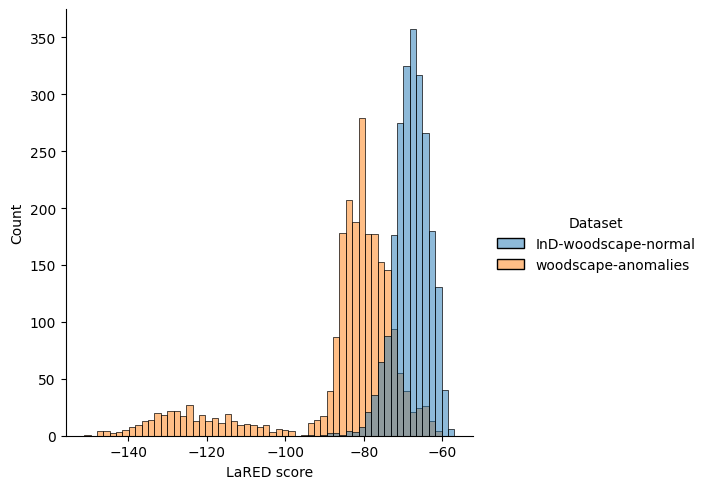

In [51]:
df_h_z_valid_scores = pd.concat([df_score_ind_ws_normal,
                                 df_score_ood_ws_anomal]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="LaRED score", hue="Dataset", kind="hist", fill=True)
plt.show()

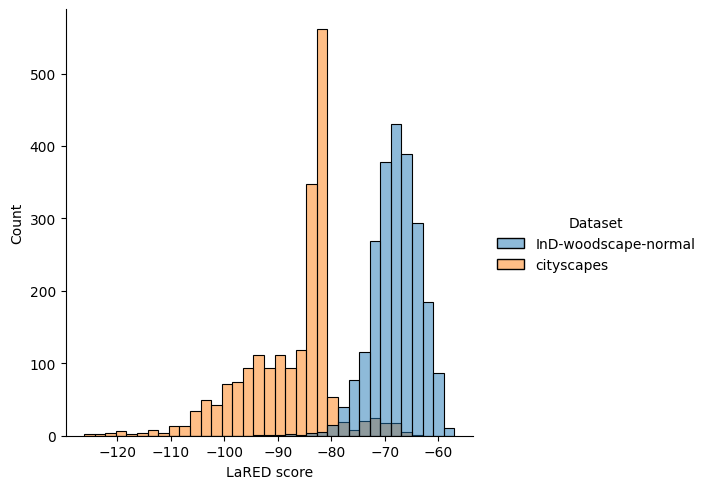

In [52]:
df_h_z_valid_scores = pd.concat([df_score_ind_ws_normal,
                                 df_score_ood_cs]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="LaRED score", hue="Dataset", kind="hist", fill=True)
plt.show()

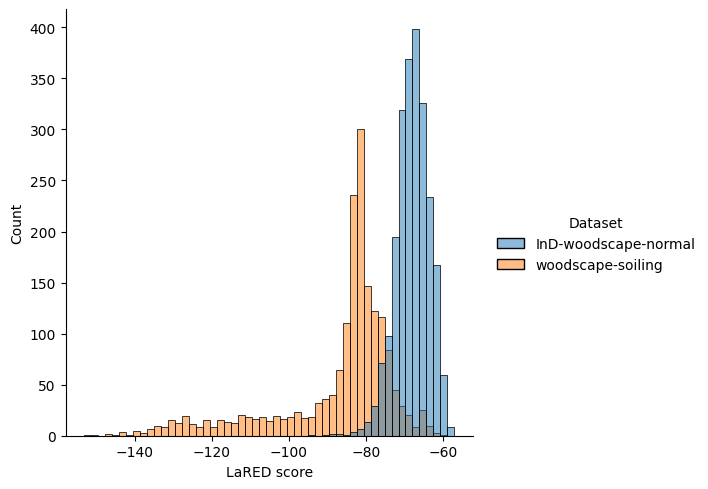

In [53]:
df_h_z_valid_scores = pd.concat([df_score_ind_ws_normal,
                                 df_score_ood_ws_soil]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="LaRED score", hue="Dataset", kind="hist", fill=True)
plt.show()

# Load Entropy

In [ ]:
data_path = "./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p/embeddings/woodscape/entropy/"

In [25]:
ws_dlv3p_h_z_ws_normal_train_samples_np = np.load(data_path + 'ws_dlv3p_h_z_ws_normal_train_samples_np.npy')

ws_dlv3p_h_z_ws_normal_valid_samples_np = np.load(data_path + 'ws_dlv3p_h_z_ws_normal_valid_samples_np.npy')

ws_dlv3p_h_z_ws_normal_test_samples_np = np.load(data_path + 'ws_dlv3p_h_z_ws_normal_test_samples_np.npy')

ws_dlv3p_h_z_ws_anomal_valid_samples_np = np.load(data_path + 'ws_dlv3p_h_z_ws_anomal_valid_samples_np.npy')

ws_dlv3p_h_z_ws_anomal_test_samples_np = np.load(data_path + 'ws_dlv3p_h_z_ws_anomal_test_samples_np.npy')

ws_dlv3p_h_z_cs_483640_valid_samples_np = np.load(data_path + 'ws_dlv3p_h_z_cs_483640_valid_samples_np.npy')

ws_dlv3p_h_z_cs_483640_test_samples_np = np.load(data_path + 'ws_dlv3p_h_z_cs_483640_test_samples_np.npy')

ws_dlv3p_h_z_ws_soil_483640_valid_samples_np = np.load(data_path + 'ws_dlv3p_h_z_ws_soil_483640_valid_samples_np.npy')

ws_dlv3p_h_z_ws_soil_483640_test_samples_np = np.load(data_path + 'ws_dlv3p_h_z_ws_soil_483640_test_samples_np.npy')

In [26]:
ic(ws_dlv3p_h_z_ws_normal_valid_samples_np.shape);
ic(ws_dlv3p_h_z_ws_normal_test_samples_np.shape);
ic(ws_dlv3p_h_z_ws_soil_483640_valid_samples_np.shape);
ic(ws_dlv3p_h_z_ws_soil_483640_test_samples_np.shape);

ic| ws_dlv3p_h_z_ws_normal_valid_samples_np.shape: (1482, 2048)
ic| ws_dlv3p_h_z_ws_normal_test_samples_np.shape: (823, 2048)
ic| ws_dlv3p_h_z_ws_soil_483640_valid_samples_np.shape: (800, 2048)
ic| ws_dlv3p_h_z_ws_soil_483640_test_samples_np.shape: (1000, 2048)


# Build Deeplabv3+-Woodscape LaREM Distribution Shift Detector 

In [27]:
ic(ws_dlv3p_h_z_ws_normal_train_samples_np.shape);
ic(ws_dlv3p_h_z_ws_normal_valid_samples_np.shape);
ic(ws_dlv3p_h_z_ws_normal_test_samples_np.shape);

ic(ws_dlv3p_h_z_ws_anomal_valid_samples_np.shape);
ic(ws_dlv3p_h_z_ws_anomal_test_samples_np.shape);

ic(ws_dlv3p_h_z_cs_483640_valid_samples_np.shape);
ic(ws_dlv3p_h_z_cs_483640_test_samples_np.shape);

ic(ws_dlv3p_h_z_ws_soil_483640_valid_samples_np.shape);
ic(ws_dlv3p_h_z_ws_soil_483640_test_samples_np.shape);

ic| ws_dlv3p_h_z_ws_normal_train_samples_np.shape: (5929, 2048)


ic| ws_dlv3p_h_z_ws_normal_valid_samples_np.shape: (1482, 2048)
ic| ws_dlv3p_h_z_ws_normal_test_samples_np.shape: (823, 2048)
ic| ws_dlv3p_h_z_ws_anomal_valid_samples_np.shape: (1482, 2048)
ic| ws_dlv3p_h_z_ws_anomal_test_samples_np.shape: (823, 2048)
ic| ws_dlv3p_h_z_cs_483640_valid_samples_np.shape: (500, 2048)
ic| ws_dlv3p_h_z_cs_483640_test_samples_np.shape: (1525, 2048)
ic| ws_dlv3p_h_z_ws_soil_483640_valid_samples_np.shape: (800, 2048)
ic| ws_dlv3p_h_z_ws_soil_483640_test_samples_np.shape: (1000, 2048)


## Build Detector LaREMd

In [28]:
from sklearn.covariance import EmpiricalCovariance

class LaREMPostprocessor:
    def __init__(self,
                 setup_flag: bool = False,
                 get_2d_rep_mean: bool = False):

        self.setup_flag = setup_flag
        self.get_2d_rep_mean = get_2d_rep_mean
        self.feats_mean = None
        self.precision = None

    def setup(self,
              ind_feats: np.ndarray):
        
        if not self.setup_flag:
            # estimate mean and variance from training set
            print('\n Estimating mean and variance from training set...')

            self.feats_mean = ind_feats.mean(0)
            self.feats_mean = np.mean(ind_feats, 0, keepdims=True)
            
            self.centered_data = ind_feats - self.feats_mean
              
            group_lasso = EmpiricalCovariance(assume_centered=False)
            group_lasso.fit(self.centered_data)
            
            self.precision = group_lasso.precision_
            
            self.setup_flag = True
            # we need to use:
            # self.feats_mean & self.precision
        else:
            pass

    def postprocess(self,
                    ood_feats: np.ndarray):
           
        diff = ood_feats - self.feats_mean
        conf_score = -np.diag(np.matmul(np.matmul(diff, self.precision), np.transpose(diff)))

        return conf_score

In [29]:
ws_dlv3p_larem_detector = LaREMPostprocessor()

In [30]:
ws_dlv3p_larem_detector.setup(ws_dlv3p_h_z_ws_normal_train_samples_np)


 Estimating mean and variance from training set...


In [31]:
ic(ws_dlv3p_larem_detector.feats_mean.shape);
ic(ws_dlv3p_larem_detector.precision.shape);

ic| ws_dlv3p_larem_detector.feats_mean.shape: (1, 2048)
ic| ws_dlv3p_larem_detector.precision.shape: (2048, 2048)


In [32]:
ind_ws_valid_larem_score = ws_dlv3p_larem_detector.postprocess(ws_dlv3p_h_z_ws_normal_valid_samples_np)
ic(ind_ws_valid_larem_score.shape);
ind_ws_test_larem_score = ws_dlv3p_larem_detector.postprocess(ws_dlv3p_h_z_ws_normal_test_samples_np)
ic(ind_ws_test_larem_score.shape);


ood_ws_anomal_valid_larem_score = ws_dlv3p_larem_detector.postprocess(ws_dlv3p_h_z_ws_anomal_valid_samples_np)
ic(ood_ws_anomal_valid_larem_score.shape);
ood_ws_anomal_test_larem_score = ws_dlv3p_larem_detector.postprocess(ws_dlv3p_h_z_ws_anomal_test_samples_np)
ic(ood_ws_anomal_test_larem_score.shape);


ood_cs_valid_larem_score = ws_dlv3p_larem_detector.postprocess(ws_dlv3p_h_z_cs_483640_valid_samples_np)
ic(ood_cs_valid_larem_score.shape);
ood_cs_test_larem_score = ws_dlv3p_larem_detector.postprocess(ws_dlv3p_h_z_cs_483640_test_samples_np)
ic(ood_cs_test_larem_score.shape);


ood_ws_soil_valid_larem_score = ws_dlv3p_larem_detector.postprocess(ws_dlv3p_h_z_ws_soil_483640_valid_samples_np)
ic(ood_ws_soil_valid_larem_score.shape);
ood_ws_soil_test_larem_score = ws_dlv3p_larem_detector.postprocess(ws_dlv3p_h_z_ws_soil_483640_test_samples_np)
ic(ood_ws_soil_test_larem_score.shape);

ic| ind_ws_valid_larem_score.shape: (1482,)
ic| ind_ws_test_larem_score.shape: (823,)
ic| ood_ws_anomal_valid_larem_score.shape: (1482,)
ic| ood_ws_anomal_test_larem_score.shape: (823,)
ic| ood_cs_valid_larem_score.shape: (500,)
ic| ood_cs_test_larem_score.shape: (1525,)
ic| ood_ws_soil_valid_larem_score.shape: (800,)
ic| ood_ws_soil_test_larem_score.shape: (1000,)


In [34]:
ws_dlv3p_ind_ws_larem_scores = np.concatenate((ind_ws_valid_larem_score,
                                               ind_ws_test_larem_score))

ws_dlv3p_ood_ws_anomal_larem_scores = np.concatenate((ood_ws_anomal_valid_larem_score,
                                                      ood_ws_anomal_test_larem_score))

ws_dlv3p_ood_cs_larem_scores = np.concatenate((ood_cs_valid_larem_score,
                                               ood_cs_test_larem_score))

ws_dlv3p_ood_ws_soil_larem_scores = np.concatenate((ood_ws_soil_valid_larem_score,
                                                    ood_ws_soil_test_larem_score))

ic(ws_dlv3p_ind_ws_larem_scores.shape);
ic(ws_dlv3p_ood_ws_anomal_larem_scores.shape);
ic(ws_dlv3p_ood_cs_larem_scores.shape);
ic(ws_dlv3p_ood_ws_soil_larem_scores.shape);

ic| ws_dlv3p_ind_ws_larem_scores.shape: (2305,)


ic| ws_dlv3p_ood_ws_anomal_larem_scores.shape: (2305,)
ic| ws_dlv3p_ood_cs_larem_scores.shape: (2025,)
ic| ws_dlv3p_ood_ws_soil_larem_scores.shape: (1800,)


In [38]:
ic(ws_dlv3p_ind_ws_larem_scores.shape);
ic(ws_dlv3p_ood_ws_anomal_larem_scores.shape);

results_ws_anomal = get_hz_detector_results(detect_exp_name="woodscape vs. woodscape-anomalies",
                                            ind_samples_scores=ws_dlv3p_ind_ws_larem_scores,
                                            ood_samples_scores=ws_dlv3p_ood_ws_anomal_larem_scores)

ic| ws_dlv3p_ind_ws_larem_scores.shape: (2305,)


ic| ws_dlv3p_ood_ws_anomal_larem_scores.shape: (2305,)


AUROC: 0.9278
FPR95: 0.2972
AUPR: 0.8850


In [39]:
ic(ws_dlv3p_ind_ws_larem_scores.shape);
ic(ws_dlv3p_ood_cs_larem_scores.shape);

results_cs = get_hz_detector_results(detect_exp_name="woodscape vs. cityscapes",
                                     ind_samples_scores=ws_dlv3p_ind_ws_larem_scores,
                                     ood_samples_scores=ws_dlv3p_ood_cs_larem_scores)

ic| ws_dlv3p_ind_ws_larem_scores.shape: (2305,)
ic| ws_dlv3p_ood_cs_larem_scores.shape: (2025,)


AUROC: 0.9652
FPR95: 0.0543
AUPR: 0.9488


In [40]:
ic(ws_dlv3p_ind_ws_larem_scores.shape);
ic(ws_dlv3p_ood_ws_soil_larem_scores.shape);

results_ws_soil = get_hz_detector_results(detect_exp_name="woodscape vs. woodscape-soiling",
                                          ind_samples_scores=ws_dlv3p_ind_ws_larem_scores,
                                          ood_samples_scores=ws_dlv3p_ood_ws_soil_larem_scores)

ic| ws_dlv3p_ind_ws_larem_scores.shape: (2305,)


ic| ws_dlv3p_ood_ws_soil_larem_scores.shape: (1800,)


AUROC: 0.9142
FPR95: 0.2867
AUPR: 0.8914


## Plot scores

In [42]:
df_score_ind_ws_normal = pd.DataFrame(ws_dlv3p_ind_ws_larem_scores, columns=["LaREM score"])
df_score_ood_ws_anomal = pd.DataFrame(ws_dlv3p_ood_ws_anomal_larem_scores, columns=["LaREM score"])
df_score_ood_cs = pd.DataFrame(ws_dlv3p_ood_cs_larem_scores, columns=["LaREM score"])
df_score_ood_ws_soil = pd.DataFrame(ws_dlv3p_ood_ws_soil_larem_scores, columns=["LaREM score"])

df_score_ind_ws_normal.insert(0, "Dataset", "")
df_score_ind_ws_normal.loc[:, "Dataset"] = "InD-woodscape-normal"

df_score_ood_ws_anomal.insert(0, "Dataset", "")
df_score_ood_ws_anomal.loc[:, "Dataset"] = "woodscape-anomalies"

df_score_ood_cs.insert(0, "Dataset", "")
df_score_ood_cs.loc[:, "Dataset"] = "cityscapes"

df_score_ood_ws_soil.insert(0, "Dataset", "")
df_score_ood_ws_soil.loc[:, "Dataset"] = "woodscape-soiling"

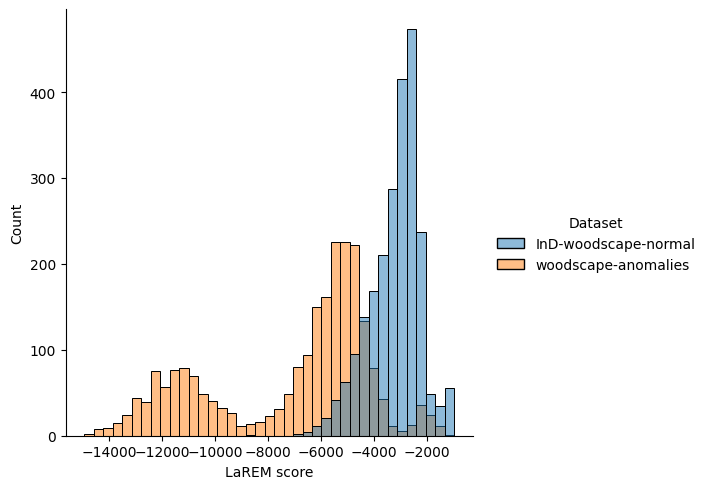

In [44]:
df_larem_scores = pd.concat([df_score_ind_ws_normal,
                             df_score_ood_ws_anomal]).reset_index(drop=True)

sns.displot(df_larem_scores, x="LaREM score", hue="Dataset", kind="hist", fill=True)
plt.show()

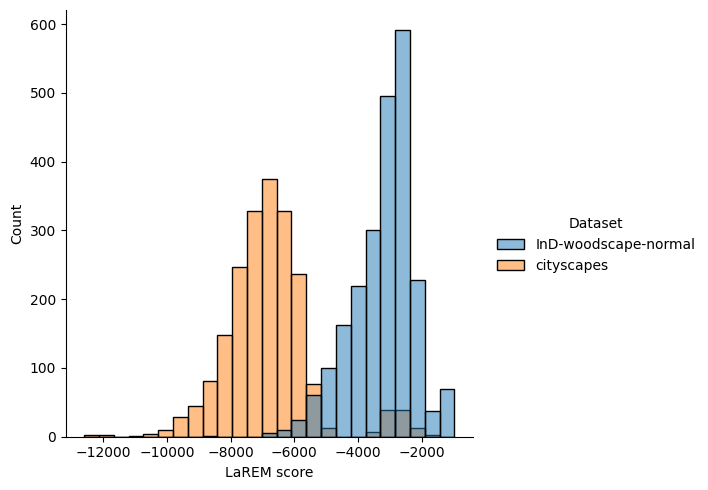

In [45]:
df_larem_scores = pd.concat([df_score_ind_ws_normal,
                             df_score_ood_cs]).reset_index(drop=True)

sns.displot(df_larem_scores, x="LaREM score", hue="Dataset", kind="hist", fill=True)
plt.show()

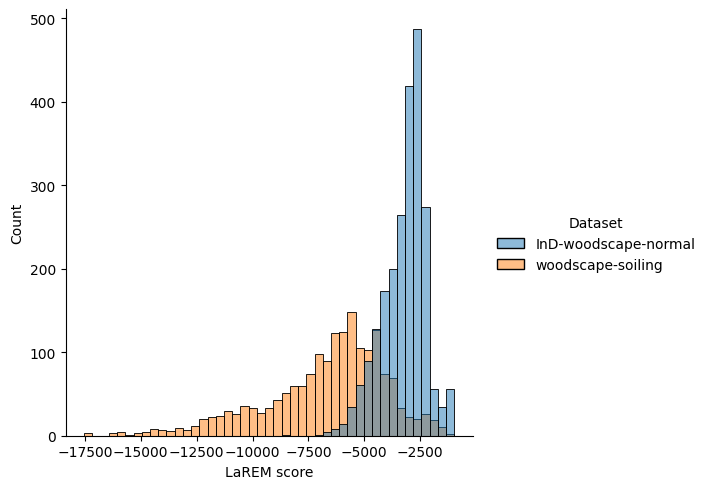

In [46]:
df_larem_scores = pd.concat([df_score_ind_ws_normal,
                             df_score_ood_ws_soil]).reset_index(drop=True)

sns.displot(df_larem_scores, x="LaREM score", hue="Dataset", kind="hist", fill=True)
plt.show()